# best model param search

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import seaborn as sns
import random 
import sys

from preprocessing import merge_dataset
from augment import temporal_scale

# Load the NetCDF file
#nc_file = 'data/derivatives/dataset_MOTOR_60_subjects_both.nc' # hrf convoluted + block, if we want to denoise data
nc_file = 'data/derivatives/dataset_MOTOR_60_subjects_both_noncens.nc'
merged = merge_dataset([
    xr.load_dataset("/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/dataset_MOTOR_100_subjects_normed.nc"),
    xr.load_dataset("/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/dataset_LANGUAGE_100_subjects_normed.nc"),
    xr.load_dataset("/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/dataset_EMOTION_100_subjects_normed.nc"),
    # xr.load_dataset("/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/dataset_WM_100_subjects_normed.nc"),
    # xr.load_dataset("/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/dataset_RELATIONAL_100_subjects_normed.nc"),
])
np.random.seed(459345)
dataset = xr.open_dataset(nc_file)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

TR=0.72

284 MOTOR
316 LANGUAGE
176 EMOTION


In [5]:
def scramble_blocks(tensor, block_size):
    """
    Scrambles the timepoints in the tensor by swapping two blocks of the given size.

    Parameters:
    - tensor: A tensor of shape (n_samples, n_timepoints)
    - block_size: The size of the blocks to swap

    Returns:
    - A tensor with scrambled blocks
    """
    n_samples, n_timepoints = tensor.shape
    
    if block_size * 2 > n_timepoints:
        raise ValueError("Block size is too large for the number of timepoints.")

    # Randomly select two block start indices
    idx1 = torch.randint(0, n_timepoints - block_size + 1, (1,)).item()
    idx2 = torch.randint(0, n_timepoints - block_size + 1, (1,)).item()

    # Ensure the two indices are distinct
    while abs(idx1 - idx2) < block_size:
        idx2 = torch.randint(0, n_timepoints - block_size + 1, (1,)).item()

    # Extract blocks
    block1 = tensor[:, idx1:idx1 + block_size]
    block2 = tensor[:, idx2:idx2 + block_size]

    # Create scrambled tensor
    scrambled = tensor.clone()  # Clone the input tensor to preserve original data
    scrambled[:, idx1:idx1 + block_size] = block2
    scrambled[:, idx2:idx2 + block_size] = block1

    return scrambled, (idx1, idx2)

In [ ]:
def augment_data(X_train, Y_train, shift_range=(-20, +20), amplitude_range=(0.5, 2), noise_std=0.1, stretch_ratio=0.6,plot_times=False):
    """
    Augment the data by shifting and scaling the time series data.
    
    Parameters:
    - X_train, Y_train Tensors for the BOLD signal and predicted signals (Y).
    - shift_range: Tuple defining the range for temporal shifts (in number of time steps).
    - amplitude_range: Tuple defining the range for amplitude scaling (scaling factor).
    
    Returns:
    - Augmented tensors for X, Y
    """
    print("Data augmentation")
    # Apply time shifts and amplitude scaling to the training set
    augmented_X = []
    augmented_Y = []
    num_samples = X_train.shape[0]
    if plot_times:
        x,y = X_train[0,:],Y_train[0,:]
        plt.plot(x,label="original")
        plt.plot(y,label='block')
        plt.legend()
        plt.show()

    for i in range(num_samples):
        # 1. Apply random time shift
        shift = np.random.randint(shift_range[0], shift_range[1] + 1)
        shifted_X = torch.roll(X_train[i], shifts=shift, dims=0)
        shifted_Y = torch.roll(Y_train[i], shifts=shift, dims=0)
        if plot_times:

            x,y = shifted_X,shifted_Y
            plt.plot(x,label="original")
            plt.plot(y,label='block')
            plt.legend()
            plt.show()
        

        # 2. Apply random amplitude scaling
        scale_factor = np.random.uniform(amplitude_range[0], amplitude_range[1])
        scaled_X = shifted_X * scale_factor
        scaled_Y = shifted_Y * scale_factor
        if plot_times:

            x,y = scaled_X,scaled_Y
            plt.plot(x,label="original")
            plt.plot(y,label='block')
            plt.legend()
            plt.show()
                
        # 4. Add Gaussian noise
        noise_std_value = noise_std*torch.max(scaled_Y).item()
        noise_X = torch.normal(mean=0, std=noise_std_value, size=scaled_X.shape, device=scaled_X.device)
        noisy_X = scaled_X + noise_X
        if plot_times:

            x,y = noisy_X,scaled_Y
            plt.plot(x,label="original")
            plt.plot(y,label='block')
            plt.legend()
            plt.show()
            plot_times-=1
        # Store augmented samples
        augmented_X.append(noisy_X)
        augmented_Y.append(scaled_Y)

    # Convert lists back to tensors
    augmented_X_tensor = torch.stack(augmented_X)
    augmented_Y_tensor = torch.stack(augmented_Y)
    
    return augmented_X_tensor, augmented_Y_tensor


def preprocess_subject_data(subject_data):
    """
    Preprocess the data for a given subject, including normalization, 
    handling missing values, and applying temporal shifts.

    Parameters:
    - subject_data: The data for a single subject.

    Returns:
    - X_tensor, Y_tensor: Preprocessed tensors for the BOLD signal and predicted signals.
    """
    print("Data preprocess")
    
    X_subject = subject_data['X']  # Shape: [voxels, time]
    Y_subject = subject_data['Y']  # Shape: [voxels, time]

    # Access time series for all voxels
    X_vals = X_subject.values
    Y_vals = Y_subject.values

    # Remove rows with NaNs in any voxel time series
    print("Remove rows with NaNs in any voxel time series")
    valid_mask = ~np.isnan(X_vals).any(axis=1)
    X_vals = X_vals[valid_mask]
    Y_vals = Y_vals[valid_mask]

    # Normalize BOLD signal (X)
    print("Normalize BOLD signal (X)")
    X_vals = (X_vals - np.mean(X_vals, axis=1, keepdims=True)) / np.std(X_vals, axis=1, keepdims=True)
    Y_vals = (Y_vals - np.mean(Y_vals, axis=1, keepdims=True)) / np.std(Y_vals, axis=1, keepdims=True)

    # Convert to PyTorch tensors
    print("Convert to PyTorch tensors")
    X_tensor = torch.tensor(X_vals, dtype=torch.float32)
    Y_tensor = torch.tensor(Y_vals, dtype=torch.float32)

    return X_tensor, Y_tensor

    #reversed_X_train = torch.flip(X_tensor, dims=[1])
    #reversed_Y_train = torch.flip(Y_tensor, dims=[1])

    #return reversed_X_train, reversed_Y_train


def concat_data(all_X_train, all_X_val, all_X_test, all_Y_train, all_Y_val, all_Y_test):
    """
    Concatenate the data from all subjects into one large dataset.

    Parameters:
    - all_X_train: List of tensors, each containing training data for a subject.
    - all_X_val: List of tensors, each containing validation data for a subject.
    - all_X_test: List of tensors, each containing test data for a subject.
    - all_Y_train: List of tensors, each containing labels for a subject.
    - all_Y_val: List of tensors, each containing labels for a subject.
    - all_Y_test: List of tensors, each containing labels for a subject.

    Returns:
    - Concatenated tensors for training, validation, and test sets.
    """

    # Concatenate lists into tensors
    X_train_def = torch.cat(all_X_train, dim=0)
    X_val_def = torch.cat(all_X_val, dim=0)
    X_test_def = torch.cat(all_X_test, dim=0).unsqueeze(-1)
    Y_train_def = torch.cat(all_Y_train, dim=0).unsqueeze(-1)
    Y_val_def = torch.cat(all_Y_val, dim=0).unsqueeze(-1)
    Y_test_def = torch.cat(all_Y_test, dim=0).unsqueeze(-1)

    return X_train_def, X_val_def, X_test_def, Y_train_def, Y_val_def, Y_test_def



In [ ]:
def custom_progress_bar(current, total, description="Processing"):
    percent = int((current / total) * 100)
    bar = f"[{'#' * (percent // 2)}{'-' * (50 - percent // 2)}] {percent}%"
    sys.stdout.write(f"\r{description}: {bar}")
    sys.stdout.flush()
def get_data_tensors(subject_ids):

    # Shuffle subject IDs
    random.seed(42)  # Set seed for reproducibility
    shuffled_subjects = subject_ids.copy()
    random.shuffle(shuffled_subjects)
    
    # Compute split indices based on percentages
    total_subjects = len(shuffled_subjects)
    train_end = int(0.6 * total_subjects)
    val_end = int(0.8 * total_subjects)
    
    # Split subjects into train, val, and test
    train_subjects = shuffled_subjects[:train_end]
    val_subjects = shuffled_subjects[train_end:val_end]
    test_subjects = shuffled_subjects[val_end:]

    all_X_train, all_X_val, all_X_test = [], [], []
    all_Y_train, all_Y_val, all_Y_test = [], [], []
    print("\nProcessing Train Subjects:")

    # Process train subjects
    for idx, train_subj in enumerate(train_subjects, 1):
        subject_data = dataset.sel(subject=train_subj)  # Extract subject data
        X_train_tensor, Y_train_tensor = preprocess_subject_data(subject_data)
        # Augment training data
        X_train_aug, Y_train_aug = augment_data(X_train_tensor, Y_train_tensor)
        # Apply temporal scaling to the augmented data
        X_train_aug, Y_train_aug = temporal_scale(X_train_aug.unsqueeze(-1), Y_train_aug)
        X_train_aug = (X_train_aug-torch.mean(X_train_aug,axis=1,keepdim=True))/torch.std(X_train_aug,axis=1,keepdim=True)
        Y_train_aug = (Y_train_aug-torch.mean(Y_train_aug,axis=1,keepdim=True))/torch.std(Y_train_aug,axis=1,keepdim=True)
        all_X_train.append(X_train_aug)
        all_Y_train.append(Y_train_aug)
        custom_progress_bar(idx, len(train_subjects))

    print("\nProcessing Validation Subjects:")
    for idx, val_subj in enumerate(val_subjects, 1):
        subject_data = dataset.sel(subject=val_subj)  # Extract subject data
        X_val_tensor, Y_val_tensor = preprocess_subject_data(subject_data)
        # Augment training data
        X_val_aug, Y_val_aug = augment_data(X_val_tensor, Y_val_tensor)
        # Apply temporal scaling to the augmented data
        X_val_aug, Y_val_aug = temporal_scale(X_val_aug.unsqueeze(-1), Y_val_aug)
        X_val_aug = (X_val_aug-torch.mean(X_val_aug,axis=1,keepdim=True))/torch.std(X_val_aug,axis=1,keepdim=True)
        Y_val_aug = (Y_val_aug-torch.mean(Y_val_aug,axis=1,keepdim=True))/torch.std(Y_val_aug,axis=1,keepdim=True)
        
        all_X_val.append(X_val_aug)
        all_Y_val.append(Y_val_aug)
        custom_progress_bar(idx, len(val_subjects))

    print("\nProcessing Test Subjects:")
    for idx, test_subj in enumerate(test_subjects, 1):
        subject_data = dataset.sel(subject=test_subj)  # Extract subject data
        X_test_tensor, Y_test_tensor = preprocess_subject_data(subject_data)
        all_X_test.append(X_test_tensor)
        all_Y_test.append(Y_test_tensor)
        custom_progress_bar(idx, len(test_subjects))

    # Concatenate data for all subjects
    X_train_def, X_val_def, X_test_def,Y_train_def, Y_val_def ,Y_test_def = concat_data(
        all_X_train, all_X_val, all_X_test, all_Y_train, all_Y_val, all_Y_test)
    print()
    print("X_train",X_train_def.shape)
    print("X_val",X_val_def.shape)
    print("X_test",X_test_def.shape)
    print("Y_train",Y_train_def.shape)
    print("Y_val",Y_val_def.shape)
    print("Y_test",Y_test_def.shape)

    return X_train_def, Y_train_def, X_test_def, Y_test_def, X_val_def, Y_val_def


In [9]:
subjects_ids = dataset.subject.values

X_train_def, Y_train_def, X_test_def, Y_test_def, X_val_def, Y_val_def = get_data_tensors(subjects_ids)


Processing Train Subjects:
Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Data augmentation
Processing: [#-------------------------------------------------] 2%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Data augmentation
Processing: [##------------------------------------------------] 5%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Data augmentation
Processing: [####----------------------------------------------] 8%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Data augmentation
Processing: [#####---------------------------------------------] 11%Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
Data augmentation
Processing: [######--------------

X_train_def shape: torch.Size([69456, 284, 1]) 
Y_train_def shape: torch.Size([69456, 284, 1])


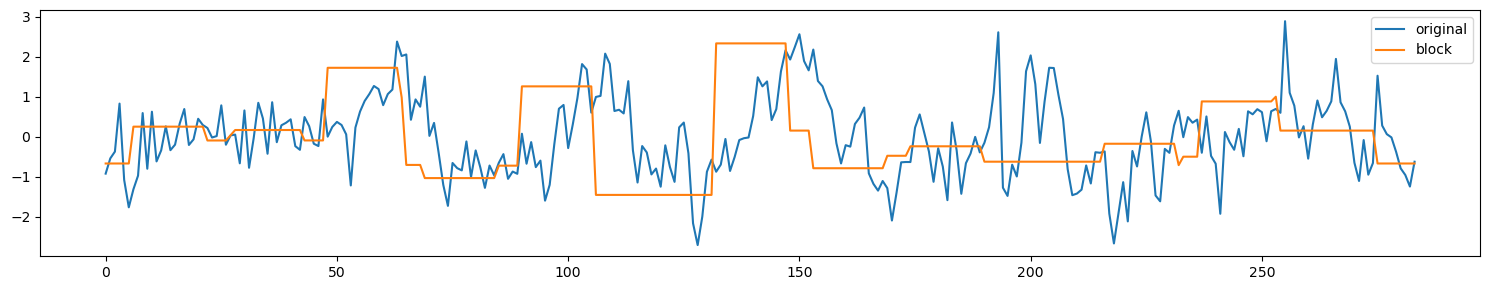

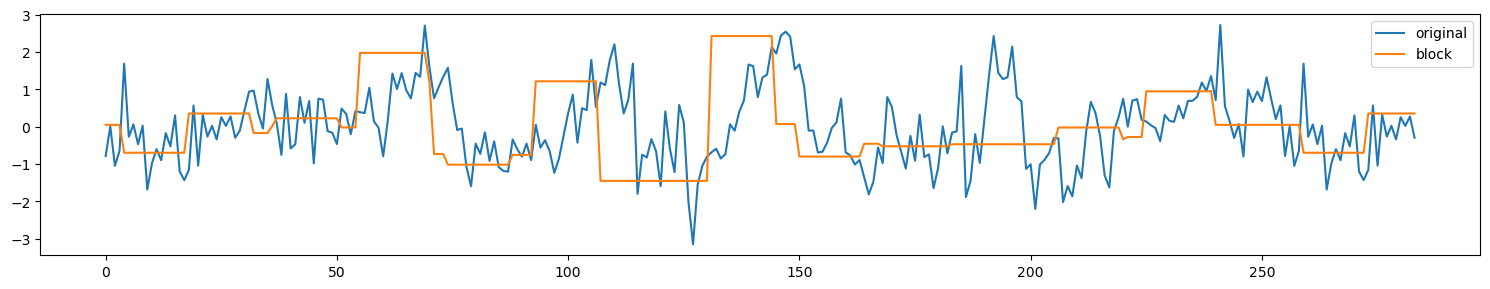

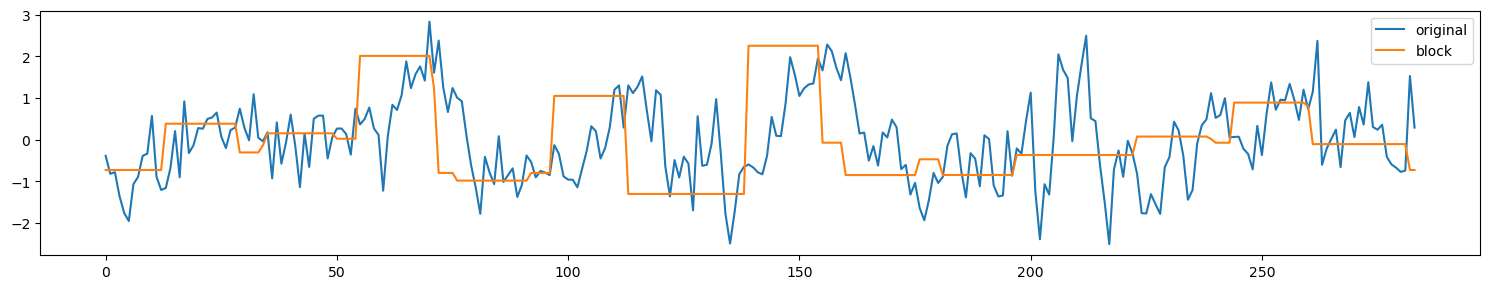

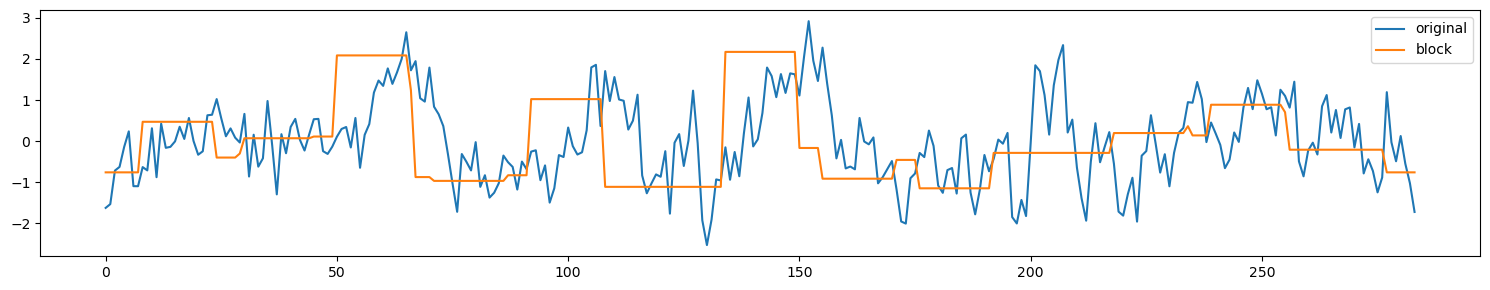

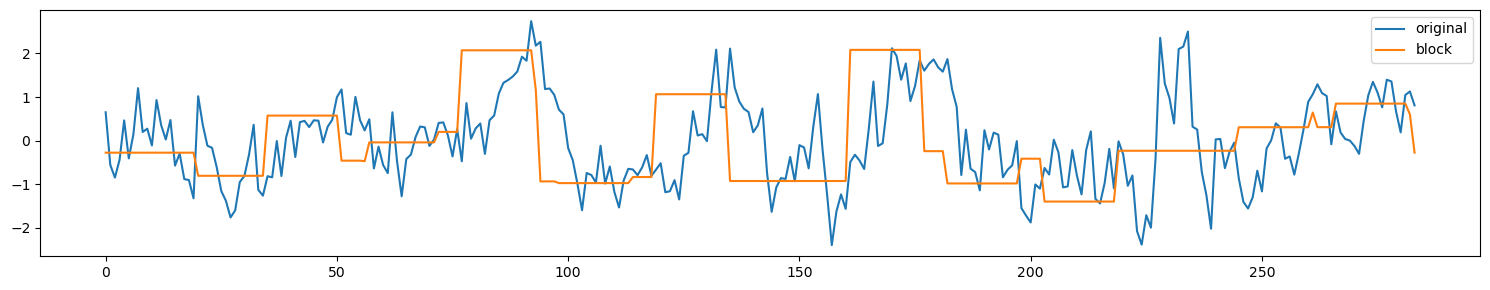

In [14]:
import matplotlib.pyplot as plt
print(f"X_train_def shape: {X_train_def.shape} \nY_train_def shape: {Y_train_def.shape}")

#X_train_def = apply_lowpass_filter(X_train_def)

for i in range (5):
    x,y = X_train_def[i,:],Y_train_def[i,:]
    plt.figure(figsize=(15, 3))
    plt.plot(x,label="original")
    plt.plot(y,label='block')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [10]:
#print(torch.cuda.is_available())
#print(torch.version.cuda)
#print(torch.backends.cudnn.enabled)
#print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.set_device(2)  # Set device to cuda:2

curr_dev=torch.cuda.current_device()
#print(curr_dev)

#print(device)

#print(torch.cuda.device(curr_dev))

#print(torch.cuda.get_device_name(curr_dev))

In [15]:
from models.rnn_cnn_rnn import RNNCNNDeconvolutionRNN

In [16]:
def gaussian_tv_penalty(predictions, alpha=0.5):
    # max is at 1/sqrt(2*alpha), needs to be searched for max gain

    # diffs is a first derivative approx
    diffs = predictions[:,1:,:] - predictions[:,:-1,:]
    # exponential weights to punish small variations
    weights = np.sqrt(2*alpha*np.e)*torch.exp(-alpha * diffs**2)

    return torch.mean(torch.abs(diffs) * weights) # normalized to have max value of 1 and min of zero, 

def anti_constant_penalty(predictions, beta=0.01):
    # Encourages non-constant solutions by penalizing non unitary variances - input and target data needs to be normalized
    varmean= torch.mean(torch.var(predictions,dim=1))
    return 1-torch.exp(-beta*torch.pow(varmean-1,2)) # penalizes variances that are not 1
    #return torch.pow(varmean-1,2) # Most likely better
    #if varmean<=1:
    #    return beta*(1/(beta+varmean))
    #return torch.tanh(varmean) # penalizes bigger than one variance 
def combined_penalty(predictions, alpha=2, beta=1e-8, lambda_tv=1, lambda_const=1):
    tv_loss = gaussian_tv_penalty(predictions, alpha)
    const_loss = anti_constant_penalty(predictions, beta)
    return (lambda_tv * tv_loss + lambda_const * const_loss)/(lambda_tv+lambda_const)

def penalize_tv(predictions):
    """
    predictions: tensor di forma [batch_size, sequence_length, num_channels]
    """
    tv_loss = torch.sum(torch.abs(predictions[:,1:, :] - predictions[:,:-1, :]))  # Penalizza variazioni consecutive
    return tv_loss 

In [17]:
fs = 1 / TR  # Hz
cutoff = 0.1  # Low-pass filter cutoff frequency (Hz)
order = 4

def butter_lowpass():
    """
    Create a lowpass Butterworth filter.
    :param cutoff: Cutoff frequency of the filter (Hz)
    :param fs: Sampling frequency of the signal (Hz)
    :param order: Order of the filter
    :return: Filter coefficients (b, a)
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    
    # Design the Butterworth filter
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    G0 = np.sum(b)/np.sum(a)
    # Normalize to ensure unit gain at zero frequency
    b = b / G0
    return b, a
    
def apply_lowpass_filter(tensor):
    """
    Apply a lowpass filter to a PyTorch tensor.
    :param tensor: PyTorch tensor to be filtered
    :param cutoff: Cutoff frequency (Hz)
    :param fs: Sampling frequency (Hz)
    :param order: Order of the filter
    :return: Filtered PyTorch tensor
    """
    # Convert the tensor to a NumPy array
    tensor_np = tensor.detach().cpu().numpy()

    print(f"Input tensor shape: {tensor_np.shape}")
    
    # Check the length of the input tensor
    if tensor_np.shape[-2] <= order:
        raise ValueError(f"Input tensor is too short for the specified filter order {order}. "
                         f"Consider increasing the length of your input signal or reducing the filter order.")
    
    # Design the filter
    b, a = butter_lowpass()
    
    # Apply the filter using filtfilt for zero-phase filtering
    filtered_np = filtfilt(b, a, tensor_np, axis=-2).copy()
    
    # Convert the filtered data back to a PyTorch tensor
    filtered_tensor = torch.tensor(filtered_np, dtype=tensor.dtype, device=tensor.device)
    
    return filtered_tensor


## hyperparameter tuning for loss function
We want to punish constant behaviour, as well as smooth functions, while punishing less block design:

In [18]:
samples = Y_val_def[:Y_val_def.shape[0]//2,:,:]
samples_punish = apply_lowpass_filter(X_val_def[:X_val_def.shape[0]//2,:,:])
# Create a tensor of zeros with the same shape
zeros_tensor = torch.zeros_like(samples_punish)

# Concatenate along the last axis
concatenated_tensor = torch.cat((samples_punish, zeros_tensor[:0,:,:]), dim=0)
print(concatenated_tensor.shape)
from itertools import product

# Define your parameter grids
alphas = [1]#np.logspace(-1, 2, 5) ## anche 2 o 8 vanno bene, leggere notion per interpretazione valore
betas = [1]#np.logspace(-2, 2 , 5)
lambdastv = [1]#np.logspace(-1, 1, 5)
lambdasconst = [0.2]#np.logspace(-1, 1, 5)

# Perform grid search
results = []
idx = 0
total_iterations = len(alphas) * len(betas) * len(lambdastv) * len(lambdasconst)

w1=2.0# loss from block design has half the samples of the other
w2=1.0
for alpha, beta, lambda_tv, lambda_const in product(alphas, betas, lambdastv, lambdasconst):
    # Compute losses
    loss = combined_penalty(samples, alpha, beta, lambda_tv, lambda_const)
    loss_punish = combined_penalty(concatenated_tensor, alpha, beta, lambda_tv, lambda_const)
    gauss_weight_samples = gaussian_tv_penalty(samples,alpha)
    gauss_weight_samples_punish = gaussian_tv_penalty(concatenated_tensor,alpha)
    constant_samples = anti_constant_penalty(samples,beta)
    constant_samples_punish = anti_constant_penalty(concatenated_tensor,beta)
    # Compute combined score
    score =  loss/loss_punish
    
    # Store results
    results.append({
        'alpha': alpha,
        'beta': beta,
        'lambda_tv': lambda_tv,
        'lambda_const': lambda_const,
        'loss': loss,
        'loss_punish': loss_punish,
        'score': score,
        'gauss_weight_samples':gauss_weight_samples,
        'gauss_weight_samples_punish':gauss_weight_samples_punish,
        'constant_samples':constant_samples,
        'constant_samples_punish':constant_samples_punish,
    })
    
    # Display progress
    idx += 1
    custom_progress_bar(idx, total_iterations)
    
# Find the best parameters based on the score
best_result = min(results, key=lambda x: x['score'])
print()
lambda_val=1/(best_result['loss']+best_result['loss_punish'])
print('lambda_train',lambda_val)

# Output the best parameters and their corresponding losses
print("Best parameters:")
print(f"Alpha: {best_result['alpha']}, Beta: {best_result['beta']}, "
      f"Lambda TV: {best_result['lambda_tv']}, Lambda Const: {best_result['lambda_const']}")
print(f"Minimum Loss: {best_result['loss']}, Maximum Loss Punish: {best_result['loss_punish']}")
print(f"Expected loss: {best_result['loss']+best_result['loss_punish']}")
print(f"Best Score: {best_result['score']}")
print(f"gass Loss: {best_result['gauss_weight_samples']}, gauss Loss Punish: {best_result['gauss_weight_samples_punish']}")
print(f"constant Loss: {best_result['constant_samples']}, constant Loss Punish: {best_result['constant_samples_punish']}")
alpha,beta,lambda_tv,lambda_const = best_result['alpha'],best_result['beta'],best_result['lambda_tv'],best_result['lambda_const']

Input tensor shape: (11606, 284, 1)
torch.Size([11606, 284, 1])
Processing: [##################################################] 100%
lambda_train tensor(3.6774)
Best parameters:
Alpha: 1, Beta: 1, Lambda TV: 1, Lambda Const: 0.2
Minimum Loss: 0.03972892463207245, Maximum Loss Punish: 0.23219874501228333
Expected loss: 0.2719276547431946
Best Score: 0.17109879851341248
gass Loss: 0.04767471179366112, gauss Loss Punish: 0.24162989854812622
constant Loss: 0.0, constant Loss Punish: 0.1850430965423584


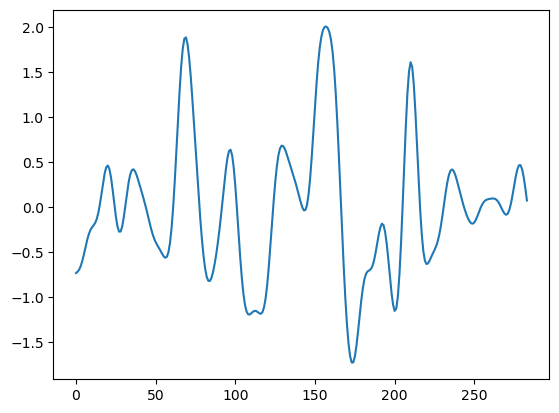

In [19]:
plt.plot(samples_punish[0,:])

In [27]:
def blocky_loss(data_loss, smoothness_loss, lambda_val=1):
    return data_loss + lambda_val * smoothness_loss

def train_model_with_early_stopping(
    model, criterion, train_loader, validation_loader, optimizer, num_epochs, device, patience=5, lambda_val=0.01,
    alpha=alpha,beta=beta,lambda_tv=lambda_tv,lambda_const=lambda_const, plot_prediction=False
):
    train_losses = []
    train_losses_smooth = []
    validation_losses = []
    validation_losses_smooth = []

    best_validation_loss = float('inf')
    patience_counter = 0
    best_model_state = None  # ensure this is defined

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        total_train_loss_smooth = 0
        last_predictions = None  # to store predictions from last batch of the epoch
        
        # Training loop
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            predictions = model(batch_x)

            # Shape check
            if predictions.shape != batch_y.shape:
                raise ValueError(
                    f"Shape mismatch: Predictions {predictions.shape} vs Targets {batch_y.shape}. "
                    "Ensure model output matches target dimensions."
                )

            loss_data = criterion(predictions, batch_y)
            smoothness_loss = combined_penalty(predictions,alpha=alpha,beta=beta,lambda_tv=lambda_tv,lambda_const=lambda_const)
            total_train_loss += loss_data.item()
            total_train_loss_smooth += smoothness_loss.item()*lambda_val

            loss = blocky_loss(loss_data, smoothness_loss, lambda_val=lambda_val)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            last_predictions = predictions.detach()
            last_y = batch_y.detach()
            last_x = batch_x.detach()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        avg_train_loss_smooth = total_train_loss_smooth/len(train_loader)
        train_losses_smooth.append(avg_train_loss_smooth)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss smooth: {avg_train_loss_smooth:.4f}")

        # Plot one prediction per epoch (using the last batch predictions)
        if last_predictions is not None and plot_prediction:
            plt.figure(figsize=(6, 4))
            # Assuming predictions: [batch, time, 1]
            plt.plot(last_x[0, :, 0].cpu().numpy(), label=f'Signal Epoch {epoch+1}',alpha=0.5)
            plt.plot(last_predictions[0, :, 0].cpu().numpy(), label=f'Prediction Epoch {epoch+1}')
            plt.plot(last_y[0, :, 0].cpu().numpy(), label=f'Target Epoch {epoch+1}')
            plt.title(f'Prediction at Epoch {epoch+1}')
            plt.xlabel('Time step')
            plt.ylabel('Prediction value')
            plt.legend()
            plt.grid(True)
            plt.show()

        # Validation phase
        model.eval()
        total_validation_loss = 0
        total_validation_loss_smooth = 0
        with torch.no_grad():
            for batch_x, batch_y in validation_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                predictions = model(batch_x)
                loss_data = criterion(predictions, batch_y)
                smoothness_loss = penalizing_function(predictions)

                total_validation_loss += loss_data.item()
                total_validation_loss_smooth += smoothness_loss.item()*lambda_val

                loss = blocky_loss(loss_data, smoothness_loss, lambda_val=lambda_val)

        avg_validation_loss = total_validation_loss / len(validation_loader)
        validation_losses.append(avg_validation_loss)
        avg_smooth = total_validation_loss_smooth/len(validation_loader)
        validation_losses_smooth.append(avg_smooth)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_validation_loss:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss smooth: {avg_smooth:.4f}")

        # Early stopping logic
        if (avg_validation_loss < best_validation_loss * 0.98): 
            best_validation_loss = avg_validation_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s).")
        
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

        # If you have a scheduler, define it outside and uncomment:
        # scheduler.step(avg_validation_loss)

    # Restore the best model weights if desired
    # model.load_state_dict(best_model_state)

    # Plot the train vs validation losses at the end
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.yscale('log') 
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses_smooth, label='Train Loss', marker='o')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses_smooth, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.yscale('log') 
    plt.ylabel('Loss')
    plt.title('Train vs Validation smoothness Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    return best_model_state


In [24]:
import torch.nn.functional as F
import pywt

# Hyperparameters
input_size = 1  # input is a single feature per voxel
hidden_size = 64
output_size = 1  # we predict one value per timeseries per voxel
num_epochs = 100
batch_size = 32
learning_rate = 0.0001
patience=15
lambda_val=lambda_val
print("Lambda val:",lambda_val)
kernel_size=40
X_train_def.to(device)
Y_train_def.to(device)
X_val_def.to(device)
Y_val_def.to(device)

train_dataset = TensorDataset(X_train_def, Y_train_def)
validation_dataset = TensorDataset(X_val_def, Y_val_def)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

#model = RNNCNNDeconvolution(input_size, hidden_size, kernel_size).to(device)
model = RNNCNNDeconvolutionRNN(input_size, hidden_size, kernel_size).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

Lambda val: tensor(3.6774)
KernelRNN input_size=1, hidden_size=64, kernel_size=40
DeconvolutionCNN kernel_size=40
OutputRNN input_size=1, hidden_size=64, output_size=1


Epoch 1/100, Train Loss: 0.4517
Epoch 1/100, Train Loss smooth: 0.2595
Epoch 1/100, Validation Loss: 0.3998
Epoch 1/100, Validation Loss smooth: 0.0895
Epoch 2/100, Train Loss: 0.4022
Epoch 2/100, Train Loss smooth: 0.1238
Epoch 2/100, Validation Loss: 0.4002
Epoch 2/100, Validation Loss smooth: 0.0704
No improvement for 1 epoch(s).
Epoch 3/100, Train Loss: 0.3949
Epoch 3/100, Train Loss smooth: 0.1019
Epoch 3/100, Validation Loss: 0.3892
Epoch 3/100, Validation Loss smooth: 0.0555
Epoch 4/100, Train Loss: 0.3909
Epoch 4/100, Train Loss smooth: 0.0905
Epoch 4/100, Validation Loss: 0.3870
Epoch 4/100, Validation Loss smooth: 0.0502
No improvement for 1 epoch(s).
Epoch 5/100, Train Loss: 0.3875
Epoch 5/100, Train Loss smooth: 0.0841
Epoch 5/100, Validation Loss: 0.3795
Epoch 5/100, Validation Loss smooth: 0.0464
Epoch 6/100, Train Loss: 0.3795
Epoch 6/100, Train Loss smooth: 0.0793
Epoch 6/100, Validation Loss: 0.3784
Epoch 6/100, Validation Loss smooth: 0.0446
No improvement for 1 epoch

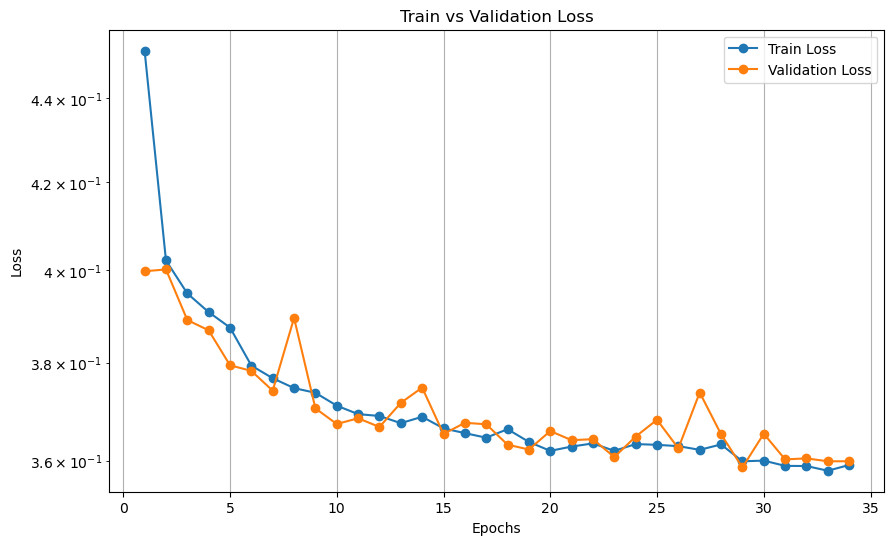

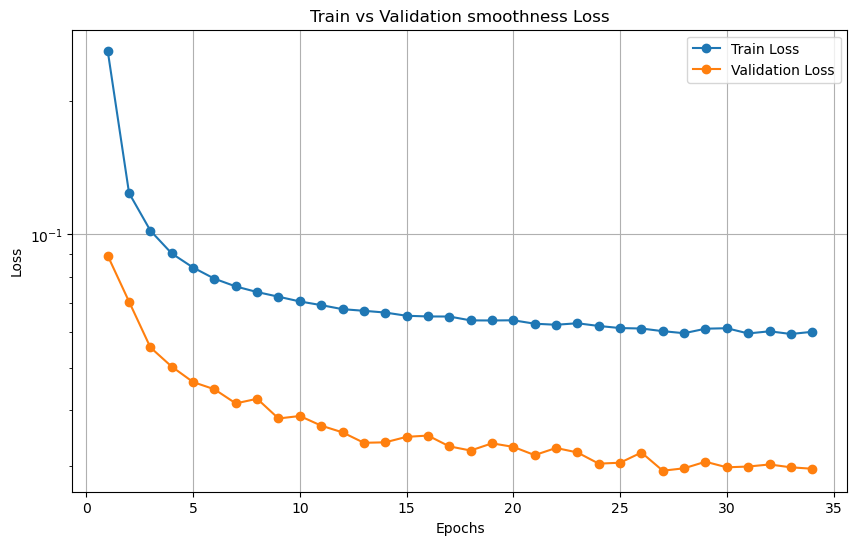

In [25]:
best_model_state = train_model_with_early_stopping(
    model, criterion, train_loader, validation_loader, optimizer, 
    num_epochs, device, patience=patience, lambda_val=lambda_val,
    alpha=alpha,beta=beta,lambda_tv=lambda_tv,lambda_const=lambda_const
)

Epoch 1/100, Train Loss: 0.3594
Epoch 1/100, Train Loss smooth: 0.0586
Epoch 1/100, Validation Loss: 0.3624
Epoch 1/100, Validation Loss smooth: 0.0275
Epoch 2/100, Train Loss: 0.3575
Epoch 2/100, Train Loss smooth: 0.0585
Epoch 2/100, Validation Loss: 0.3629
Epoch 2/100, Validation Loss smooth: 0.0310
No improvement for 1 epoch(s).
Epoch 3/100, Train Loss: 0.3571
Epoch 3/100, Train Loss smooth: 0.0590
Epoch 3/100, Validation Loss: 0.3565
Epoch 3/100, Validation Loss smooth: 0.0289
No improvement for 2 epoch(s).
Early stopping triggered at epoch 3.


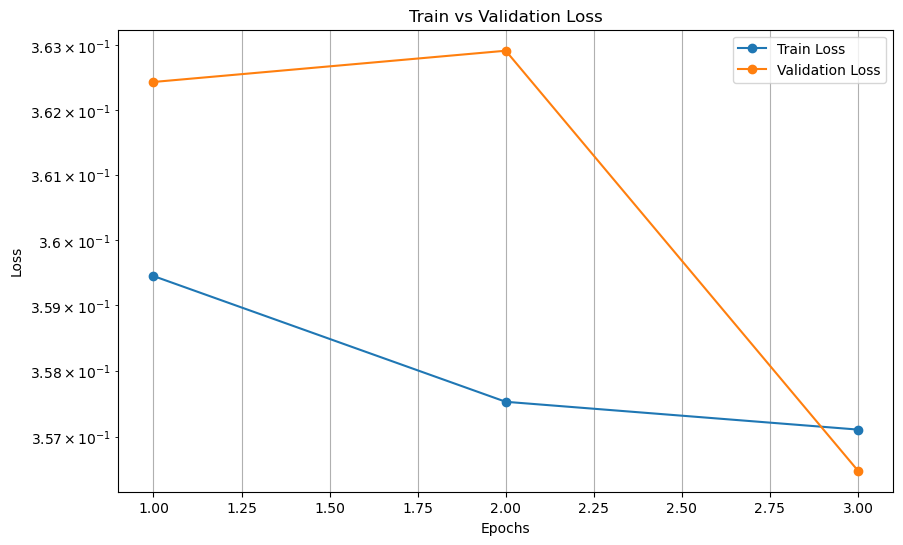

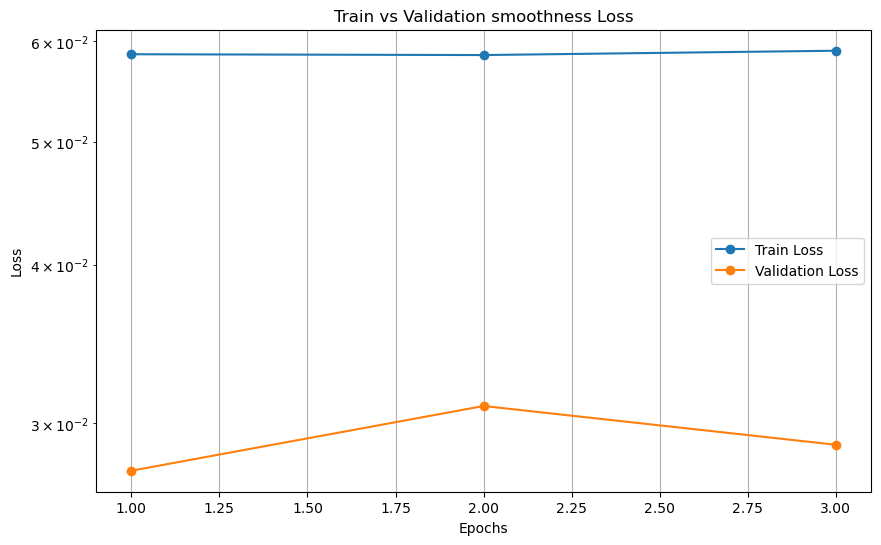

In [28]:
best_model_state = train_model_with_early_stopping(
    model, 
    criterion, 
    train_loader, 
    validation_loader, 
    optimizer, 
    num_epochs, 
    device, 
    patience=2, 
    lambda_val=lambda_val,
    alpha=alpha,
    beta=beta,
    lambda_tv=lambda_tv,
    lambda_const=lambda_const
)

In [1]:
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
import numpy as np
import xarray as xr
import torch
from run import preprocess_dataset, create_train_test_split
from augment import select_augmentation, shift, temporal_scale
from model_selection import pretty_print

from models.rnn_cnn_rnn import RNNCNNDeconvolutionRNN, RNNCNNDeconvolutionRNNTrainer
from models.bi_lstm import BiLSTMModel, BiLSTMTrainer
from models.cnn_rnn import CNNRNNModel, CNNRNNTrainer
from model_selection import select_model, prepare_bold_input, prepare_target_input

In [2]:
DATASET = 'data/derivatives/dataset_MOTOR_20_subjects_both.nc' 
N_SUBJECTS = 10

def load_data():
    dataset = xr.open_dataset(DATASET)
    selected_subjects = np.random.choice(dataset.subject.values, size=N_SUBJECTS, replace=False)
    subset_dataset = dataset.sel(subject=selected_subjects)
    return subset_dataset

In [3]:
def grid_search(models_and_trainers, X_train, y_train, n_folds=5):
    def cleanup_gpu():
        return
        import gc
        gc.collect()
        torch.cuda.empty_cache()

    # Define grid search parameters
    param_grid = {
        'hidden_size': [32, 64, 100],
        'kernel_size': [20, 40, 60],
        'batch_size': [16]
    }
    
    best_score = float('inf')
    best_results = None
    subjects = X_train.subject.values
    gkf = GroupKFold(n_splits=n_folds)
    splits = list(gkf.split(X_train, groups=subjects))

    # Prepare data tensors for each fold
    X_tensors = {}
    y_tensors = {}
    for fold_idx, (train_idx, val_idx) in enumerate(splits):
        X_fold_train = X_train.isel(subject=train_idx)
        X_fold_val = X_train.isel(subject=val_idx)
        y_fold_train = y_train.isel(subject=train_idx)
        y_fold_val = y_train.isel(subject=val_idx)
        
        X_tensors[fold_idx] = {
            'train': prepare_bold_input(X_fold_train),
            'val': prepare_bold_input(X_fold_val)
        }
        y_tensors[fold_idx] = {
            'train': prepare_target_input(y_fold_train),
            'val': prepare_target_input(y_fold_val)
        }

    for ModelClass, TrainerClass in models_and_trainers:
        from itertools import product
        param_combinations = [dict(zip(param_grid.keys(), v)) 
                            for v in product(*param_grid.values())]
        
        for params in param_combinations:
            # cleanup_gpu()  # Clean before each parameter combination
            
            full_params = {
                'input_size': 1,
                'output_size': 1,
                'loss_fn': 'blocky_loss',
                'training_logic': 'fixed',
                'dropout_prob': 0.1,
                **params
            }
            
            pretty_print(full_params)
            
            model_params = {
                'input_size': full_params['input_size'],
                'hidden_size': full_params['hidden_size'],
                'kernel_size': full_params['kernel_size'],
                'output_size': full_params['output_size'],
            }
            
            fold_scores = []
            for fold_idx in range(n_folds):
                try:
                    cleanup_gpu()  # Clean before each fold
                    
                    model = ModelClass(**model_params)
                    trainer = TrainerClass(model=model, config=full_params)
                    
                    X_fold_train = X_tensors[fold_idx]['train']
                    X_fold_val = X_tensors[fold_idx]['val']
                    y_fold_train = y_tensors[fold_idx]['train']
                    y_fold_val = y_tensors[fold_idx]['val']
                    
                    # Move to CPU after getting scores
                    trainer.train(X_fold_train, y_fold_train)
                    fold_score = trainer.evaluate(X_fold_val, y_fold_val)
                    print(f"Fold {fold_idx} score: {fold_score}")
                    
                    fold_scores.append(fold_score)
                
                finally:
                    # Cleanup regardless of success/failure
                    if 'model' in locals(): del model
                    if 'trainer' in locals(): del trainer
                    cleanup_gpu()
            
            if fold_scores:  # Only if we have valid scores
                mean_score = np.mean(fold_scores)
                print(f"Mean score: {mean_score}")
                
                if mean_score < best_score:
                    best_score = mean_score
                    best_results = (ModelClass, TrainerClass, full_params)
                    print(f"New best score: {best_score}")
                    print("Best parameters:")
                    pretty_print(full_params)
    
    cleanup_gpu()  # Final cleanup
    
    if best_results is None:
        return None, None, None
        
    ModelClass, TrainerClass, best_params = best_results
    
    model_params = {
        'input_size': best_params['input_size'],
        'hidden_size': best_params['hidden_size'],
        'output_size': best_params['output_size'],
        'kernel_size': best_params['kernel_size']
    }
    
    model = ModelClass(**model_params)
    trainer = TrainerClass(model=model, config=best_params)
    
    return model, trainer, best_params

In [4]:
def select_model_params():
    dataset = preprocess_dataset(load_data())

    train, test = create_train_test_split(dataset)
    X_train, X_test, y_train, y_test = train.X, test.X, train.Y, test.Y

    n_subjects_train, n_voxels_train, n_timepoints_train = X_train.shape
    n_subjects_test, n_voxels_test, n_timepoints_test = X_test.shape
    print("train shape", X_train.shape, "test shape", X_test.shape)
    print((n_subjects_train * n_voxels_train, n_timepoints_train, 1))
    print((n_subjects_test * n_voxels_test, n_timepoints_test, 1))

    # select the best model given raw data
    # models_and_trainers = [(BiLSTMModel, BiLSTMTrainer), (CNNRNNModel, CNNRNNTrainer)]
    models_and_trainers = [(RNNCNNDeconvolutionRNN, RNNCNNDeconvolutionRNNTrainer)]
    best_model, best_trainer_cls, model_params = grid_search(
        models_and_trainers, X_train, y_train, n_folds=5,
    )
    
    # select the best data augmentation for the best model - optimizing over all of them was taking forever
    # augmenters = [NoiseAugmenter, SyntheticAugmenterm, RollingAugmenter, DilationAugmenter, PickAugmenter]
    # best_augmenter, aug_params = select_augmentation(
    #     best_model, best_trainer_cls, X_train, y_train, augmenters
    # )
    
    final_model = best_trainer_cls.model_cls(**model_params)
    final_trainer = best_trainer_cls(final_model)
    
    # X_aug, y_aug = best_augmenter.augment(X_train, y_train)
    
    # final_trainer.train(X_aug, y_aug)
    final_trainer.train(X_train, X_train)
    
    test_predictions = final_trainer.predict(X_test)
    test_score = final_trainer.evaluate(X_test, y_test)

    # final_trainer.save('final_model.pt')
    
    return final_model, test_predictions, test_score

In [5]:
select_model_params()

Original shape: (10, 1989, 284)
Shape after dropping NaNs: (10, 1884, 284)
train shape (8, 1884, 284) test shape (2, 1884, 284)
(15072, 284, 1)
(3768, 284, 1)
{
  "batch_size": 16,
  "dropout_prob": 0.1,
  "hidden_size": 32,
  "input_size": 1,
  "kernel_size": 20,
  "loss_fn": "blocky_loss",
  "output_size": 1,
  "training_logic": "fixed"
}
KernelRNN input_size=1, hidden_size=32, kernel_size=20
DeconvolutionCNN kernel_size=20
OutputRNN input_size=1, hidden_size=32, output_size=1
running on cuda:1
{}
Epoch 0, Loss: 0.497885
Epoch 5, Loss: 0.336029
Epoch 10, Loss: 0.220276
evaluating
pred shape torch.Size([3768, 284, 1])
true shape torch.Size([3768, 284])
Fold 0 score: 0.44349950551986694
KernelRNN input_size=1, hidden_size=32, kernel_size=20
DeconvolutionCNN kernel_size=20
OutputRNN input_size=1, hidden_size=32, output_size=1
running on cuda:1
{}
Epoch 0, Loss: 0.531013
Epoch 5, Loss: 0.334815
Epoch 10, Loss: 0.254343
evaluating
pred shape torch.Size([3768, 284, 1])
true shape torch.Siz

KeyboardInterrupt: 